In [1]:
%matplotlib inline
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import rtmtools.lblrtm.visualisation as viz

from IPython import display

In [7]:
dir_run = os.path.join('/nuwa_cluster/home/jackyu',
                       'radiation/crd/LW/examples',
                       'separate_g_groups',
                       'study__lblnew_g1_threshold',
                       'n2o',
                       'band07_wn_1215_1380',
                       'P_50_T_250',
                       '4.e-21')
                       
path_dgdgs = os.path.join(dir_run, 'dgdgs.dat')
path_absmean = os.path.join(dir_run, 'absmean.dat')
path_fluxg = os.path.join(dir_run, 'output_fluxg.dat')
path_coolrg = os.path.join(dir_run, 'output_coolrg.dat')
path_flux = os.path.join(dir_run, 'output_flux.dat')
path_coolr = os.path.join(dir_run, 'output_coolr.dat')

In [2]:
dir_clirad = os.path.join('/nuwa_cluster/home/jackyu',
                          'radiation/clirad/LW/examples',
                          '1_0912_mdc_Steve_CLIRAD_lw',
                          'g1_threshold/',
                          'n2o',
                          'band07_wn_1215_1380',
                          'P_50_T_250',
                          '4.e-21',)

dir_g234_logmean = os.path.join(dir_clirad, 'dgs_g234logmean')
dir_g234_linearlogavgmean = os.path.join(dir_clirad, 
                                         'dgs_g234_linearlogavg')
dir_g234_linearmean = os.path.join(dir_clirad, 'dgs_g234linearmean')

In [3]:
# load clirad's coolrg

def load_clirad_coolrg(dir_clirad):
    path_coolr_k1 = os.path.join(dir_clirad, 'b07_coolr_k1.txt')
    path_coolr_k2 = os.path.join(dir_clirad, 'b07_coolr_k2.txt')
    path_coolr_k3 = os.path.join(dir_clirad, 'b07_coolr_k3.txt')
    path_coolr_k4 = os.path.join(dir_clirad, 'b07_coolr_k4.txt')
    paths_coolrg = [path_coolr_k1, 
                    path_coolr_k2, 
                    path_coolr_k3, 
                    path_coolr_k4]

    df_coolrg = pd.concat([pd.read_csv(path, header=None) 
                           for path in paths_coolrg], axis=1)

    ds = xr.Dataset()
    ds.coords['pressure'] = ('pressure', ds_coolrg.coords['pressure'])
    ds.coords['g'] = ('g', ds_coolrg.coords['g'])
    ds.coords['layer'] = ('pressure', 
                          range(1, ds_coolrg.dims['pressure'] + 1))
    ds['coolrg'] = (('pressure', 'g'), df_coolrg)

    ds_coolrg_clirad = ds
    return ds

In [8]:
# load coolrg
df = pd.read_csv(path_coolrg, sep=r'\s+')
df = df.set_index(['pressure', 'g'])
ds = xr.Dataset.from_dataframe(df)
ds.coords['layer'] = ('pressure', ds['layer'].isel(g=0))
ds_coolrg = ds

In [12]:
# load dgdgs
df = pd.read_csv(path_dgdgs, sep=r'\s+')
df = df.set_index(['g'])

ds_dgdgs = xr.Dataset.from_dataframe(df)

In [11]:
ds_coolrg_logmean = load_clirad_coolrg(dir_g234_logmean)
ds_coolrg_linearlogavgmean = load_clirad_coolrg(dir_g234_linearlogavgmean)
ds_coolrg_linearmean = load_clirad_coolrg(dir_g234_linearmean)

In [14]:
ds_dgdgs['dgs']

<xarray.DataArray 'dgs' (g: 4)>
array([ 0.67548746,  0.25323274,  0.05850653,  0.01277327])
Coordinates:
  * g        (g) int64 1 2 3 4

In [17]:
dict_coolrg = {1: ds_coolrg_linearmean,
               2: ds_coolrg_linearlogavgmean,
               3: ds_coolrg_logmean,
               4: ds_coolrg_logmean}

In [43]:
def get_coolrg_combined(dict_coolrg, ds_dgdgs):
    ds = xr.Dataset()
    #ds.coords['pressure'] = ('pressure', ds_coolrg.coords['pressure'])
    #ds.coords['layer'] = ('pressure', ds_coolrg.coords['layer'])
    #ds.coords['g'] = ('g', ds_coolrg.coords['g'])
    
    list_coolrg = [ds1['coolrg'].sel(g=g)
                   for g, ds1 in dict_coolrg.items()]
    
    ds['coolrg'] = xr.concat(list_coolrg, dim='g')\
                   .transpose('pressure', 'g')
    return ds

ds_coolrg_clirad_total = get_coolrg_combined(dict_coolrg, ds_dgdgs)





Plot: Cooling rates


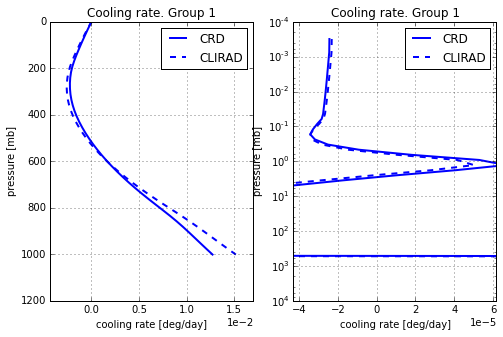

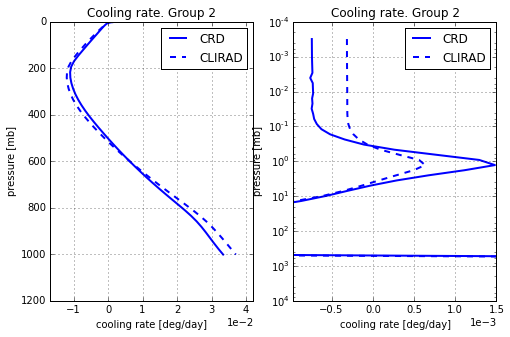

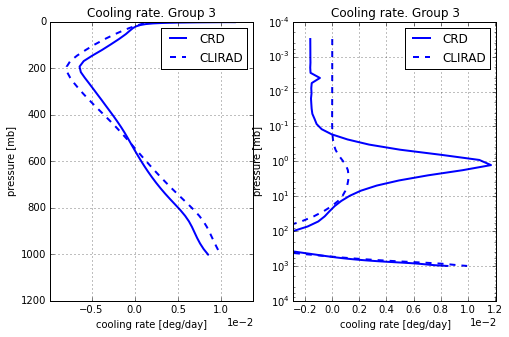

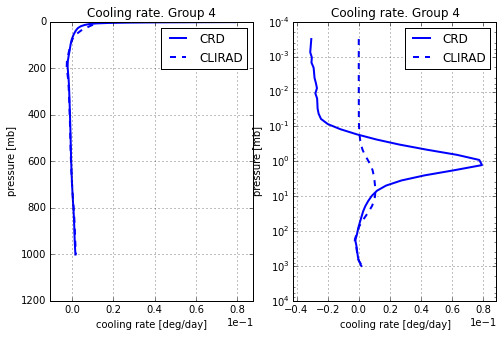

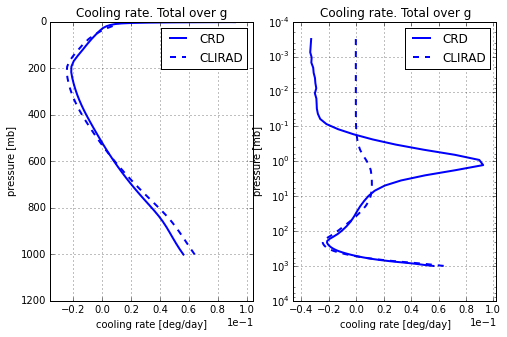

In [44]:
print(3*'\n')
print('Plot: Cooling rates')


for g in ds_coolrg.coords['g']:
    srs_crd = ds_coolrg['coolrg'].sel(g=g).to_pandas()
    srs_clirad = ds_coolrg_clirad_total['coolrg'].sel(g=g).to_pandas()
    
    srss = [srs_crd, srs_clirad]
    names = ['CRD', 'CLIRAD']
    colours = ['b', 'b']
    linestyles = ['-', '--']
    
    xlabel = 'cooling rate [deg/day]'
    ylabel = 'pressure [mb]'
    title = 'Cooling rate. Group {}'.format(int(g))
    
    fig = viz.plot_pdseries_indexVSvalues_linearlog(srss=srss,
                                                    names=names,
                                                    colours=colours,
                                                    linestyles=linestyles,
                                                    xlabel=xlabel,
                                                    ylabel=ylabel,
                                                    title=title)
    

srs_crd = ds_coolrg['coolrg'].sum('g').to_pandas()
srs_clirad = ds_coolrg_clirad_total['coolrg'].sum('g').to_pandas()

srss = [srs_crd, srs_clirad]
title = 'Cooling rate. Total over g'
fig = viz.plot_pdseries_indexVSvalues_linearlog(srss=srss,
                                                names=names,
                                                colours=colours,
                                                linestyles=linestyles,
                                                xlabel=xlabel,
                                                ylabel=ylabel,
                                                title=title)